# Large Scale Kernel Models

_Author:_ [Giacomo Turri](https://github.com/g-turri)

This tutorial explains how to train kernel-based estimators of the Koopman operator via the {class}`kooplearn.kernel.KernelRidge` and {class}`kooplearn.kernel.NystroemKernelRidge` classes. We show the performance of the following estimators:

- Reduced Rank Regression (RRR) as described in {cite:p}`Kostic2022`,
- Nyström Reduced Rank Regression (Nyström-RRR) as described in {cite:p}`Meanti2023`,
- Randomized Reduced Rank Regression (Randomized-RRR) as described in {cite:p}`Turri2023`

by investigating the Lorenz-63 System (a.k.a. Lorenz attractor). This model is defined by a system of three coupled ordinary differential equations:

$$
  \begin{align}
  \dot{x} &= \sigma (y - x), \\
  \dot{y} &= x (\rho - z) - y, \\
  \dot{z} &= x y - \beta z
  \end{align}
$$

where:
- $x, y, z$ are the three variables representing the state of the system;
- $t$ is time;
- $\sigma$, $\rho$, and $\beta$ are parameters of the system.

In this notebook, we study the "canonical" configuration $\sigma=10$, $\rho=28$, and $\beta=8/3$. In this configuration, the Lorenz-63 system exhibits a chaotic attractor known as the Lorenz attractor, which is a butterfly-shaped trajectory in state space. First, let's check if kooplearn is installed, and install it otherwise.

In [2]:
import importlib

try:
  importlib.import_module('kooplearn')
except ImportError:
  module = 'kooplearn[full]'
  %pip install -q {module}

### Data

In `kooplearn`, we provide an implementation of the Lorenz-63 system in {class}`kooplearn.datasets.Lorenz63`. With this class, we sample the dataset by setting the initial condition `X0` equal to 1 for the three components, the number of time steps `T` according to the sample sizes defined above.

In [3]:
import numpy as np
from kooplearn.datasets import Lorenz63

train_samples = 10000
test_samples = 100
raw_data = Lorenz63().sample(X0 = np.ones(3), T=train_samples + 1000 + test_samples)
# Data rescaling
mean = np.mean(raw_data, axis=0)
norm = np.max(np.abs(raw_data), axis=0)
data = raw_data - mean
data /= norm

train_set = data[:train_samples + 1]
test_set = data[-test_samples - 1:]

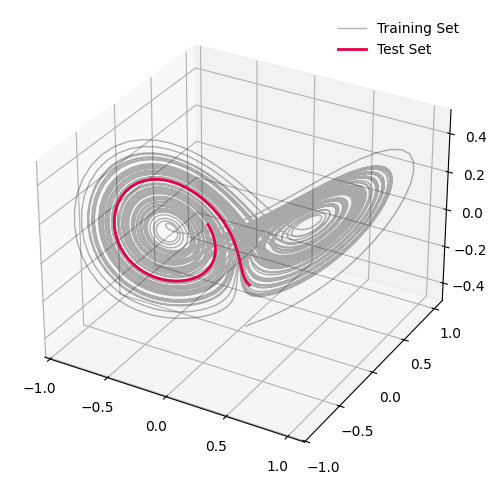

In [4]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot(train_set.x.values, train_set.y.values, train_set.z.values, lw=1, label='Training Set', color='k', alpha=0.3)
ax.plot(test_set.x.values, test_set.y.values, test_set.z.values, lw=2, label='Test Set', color='#e60049')
ax.set_xticks(np.linspace(-1,1,5),)
ax.set_yticks(np.linspace(-1,1,5))

plt.legend(frameon=False)
plt.show()

### Fitting the kernel-based estimators

The first step in training the estimators is the choice of the kernel. In this example, we choose the standard [Gaussian kernel](https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.kernels.RBF.html) and set its length scale using [median heuristic](https://arxiv.org/abs/1707.07269).

Then, the hyperparameters to be tuned, common to the three estimators under consideration, are:
- The Tikhonov regularization, `alpha`, which should be a small positive number to ensure stability and generalizability,
- The rank of the model, `n_components`, which depends on the system being analyzed.

For RRR and Nyström-RRR models we can choose the `eigen_solver` to be `full`, computing the exact SVD decomposition with LAPACK sover, or `arnoldi`, exploiting arnoldi iterations with ARPACK solver.

Moreover, for Nyström-RRR model we can set the number of Nyström centers, `n_centers`, where we look for a tradeoff between a fast model to train (small value) and an accurate model (large value).

Finally, in the randomized-RRR model which leverages Gaussian sketching, we can set:
- `iterated_power` *(int)*, the number of power iterations,
- `n_oversamples` *(int)*, the number of oversamples,
- `optimal_sketching` *(bool)*, whether performing optimal sketching or not.

In [23]:
from kooplearn.kernel import KernelRidge, NystroemKernelRidge
from scipy.spatial.distance import pdist

# Base settings
reduced_rank = True
n_components = 25
n_centers = 500
alpha = 1e-6

# Setting the RBF length scale (gamma) through the median_heuristic
data_pdist2 = pdist(train_set) ** 2
gamma = np.sqrt(np.median(data_pdist2) / 2)

We define some utility functions to measure fitting time and evaluate the RMSE of the one-step prediction on the test set.

In [24]:
from time import perf_counter
import functools


def timer(func):
    # Adapted from https://realpython.com/python-timer/#creating-a-python-timer-decorator
    @functools.wraps(func)
    def wrapper_timer(*args, **kwargs):
        tic = perf_counter()
        value = func(*args, **kwargs)
        toc = perf_counter()
        elapsed_time = toc - tic
        return value, elapsed_time

    return wrapper_timer

def runner(model, train_set):
    # Compute fit time and one-step rmse
    model, fit_time = timer(model.fit)(train_set)
    # One-step prediction
    X_test = train_set[:-model.lag_time]
    Y_test = train_set[model.lag_time :]
    Y_pred = model.predict(X_test)
    rmse = np.sqrt(np.mean((Y_pred - Y_test) ** 2))
    return fit_time, rmse


We evaluate different estimators as a function of the training sample size.

In [ ]:
from collections import defaultdict
train_stops = np.logspace(2, 4, 5).astype(int)

timings = defaultdict(list)
errors = defaultdict(list)
for stop in train_stops:
    # Reduced Rank Regression
    model = KernelRidge(
        n_components=n_components,
        reduced_rank=reduced_rank,
        kernel="rbf",
        gamma=gamma,
        alpha=alpha,
        eigen_solver="arpack",
        random_state=0,
    )
    fit_time, rmse = runner(model, train_set[:stop])
    timings["RRR"].append(fit_time)
    errors["RRR"].append(rmse)
    # Nystroem Reduced Rank Regression
    model = NystroemKernelRidge(
        n_components=n_components,
        reduced_rank=reduced_rank,
        kernel="rbf",
        gamma=gamma,
        alpha=alpha,
        eigen_solver="arpack",
        n_centers=n_centers,
        random_state=0,
    )
    fit_time, rmse = runner(model, train_set[:stop])
    timings["Nystroem-RRR"].append(fit_time)
    errors["Nystroem-RRR"].append(rmse)
    # Randomized Reduced Rank Regression
    model = KernelRidge(
        n_components=n_components,
        reduced_rank=reduced_rank,
        kernel="rbf",
        gamma=gamma,
        alpha=alpha,
        eigen_solver="randomized",
        iterated_power=1,
        n_oversamples=5,
        random_state=0,
    )
    fit_time, rmse = runner(model, train_set[:stop])
    timings["Randomized-RRR"].append(fit_time)
    errors["Randomized-RRR"].append(rmse)

# Compute speedups with respect to vanilla RRR
speedup = {}
estimators = list(timings.keys())
for name in estimators:
    speedup[name] = np.array(timings["RRR"]) / np.array(timings[name])
colors = {
    "RRR": "#e60049",
    "Nystroem-RRR":    "#0bb4ff",
    "Randomized-RRR":   "#00bfa0",
}

We can observe how the RMSE of the three the models is close to each other and decreases as the number of training points increases, while the fitting time is considerably reduced by both Nystroem and Randomized approaches, compared to the vanilla RRR.

Average fitting time speed-up for RRR: 1.00x
Average fitting time speed-up for Nystroem-RRR: 16.47x
Average fitting time speed-up for Randomized-RRR: 10.29x


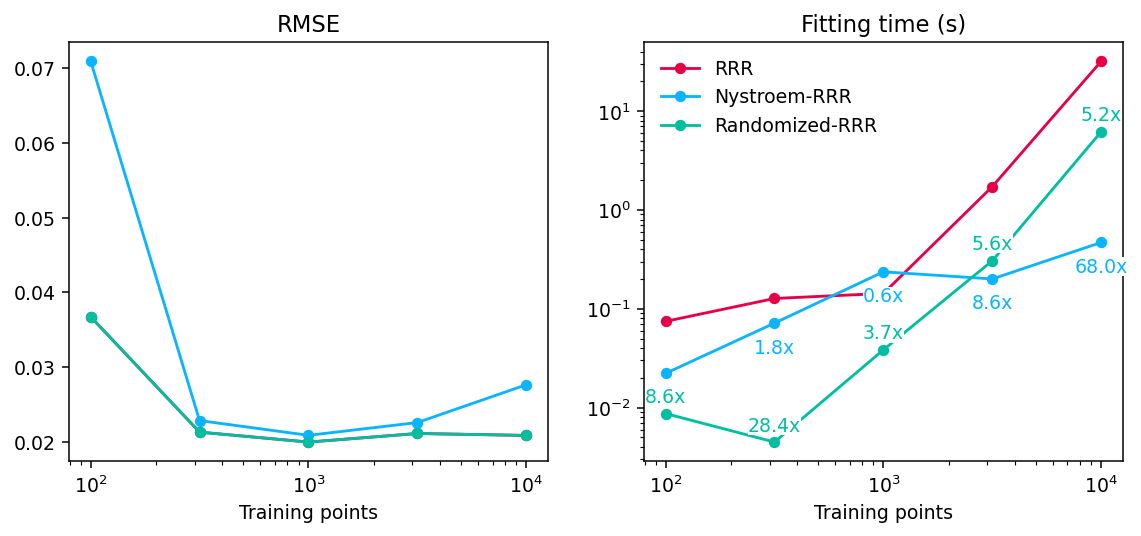

In [59]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 4), dpi=136)
for name in estimators:
    axes[0].plot(
        train_stops, errors[name], ".-", c=colors[name], label=name, markersize=10
    )
    axes[1].plot(
        train_stops, timings[name], ".-", c=colors[name], label=name, markersize=10
    )


axes[0].set_title("RMSE")
axes[1].set_title("Fitting time (s)")
axes[1].legend(frameon=False, loc="upper left")
axes[1].set_yscale("log")

for ax in axes:
    ax.set_xscale("log")
    ax.set_xlabel("Training points")

ax = axes[1]
for name in estimators:
    for i, el in enumerate(speedup[name]):
        if name == "Randomized-RRR":
            ax.text(
                train_stops[i],
                timings[name][i]*1.3,
                f"{el:.1f}x",
                fontsize=10,
                color=colors[name],
                ha="center",
                bbox=dict(facecolor='white', 
                  edgecolor='none',  # Remove border if desired
                  pad=0.)
            )
        elif name == "Nystroem-RRR":
            ax.text(
                train_stops[i],
                timings[name][i]*.5,
                f"{el:.1f}x",
                fontsize=10,
                color=colors[name],
                ha="center",
                bbox=dict(facecolor='white', 
                  edgecolor='none',  # Remove border if desired
                  pad=0.)
            )
        else:
            pass
    print(f"Average fitting time speed-up for {name}: {np.mean(speedup[name]):.2f}x")